For this time series analysis, we use the masked NDVI GeoTIFFs such that only the pixel values are taken into account which belong to the crop landuse.

In [17]:
# Import packages
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from statsmodels.tsa.seasonal import STL
import numpy as np
from sklearn.linear_model import LinearRegression
import datetime as dt
from matplotlib.colors import TwoSlopeNorm
import time
from rasterstats import zonal_stats
from osgeo import gdal
import re
import plotly.express as px
from scipy.stats import pearsonr

In [18]:
# Import district boundaries
district_bounds = gpd.read_file('C:/Users/mieke/Documents/Msc Thesis/GitHub repositories/dicra/src/data_preprocessing/tsdm/District_Boundary.shp')
district_bounds = district_bounds.reset_index()
# Import mandal boundaries
mandal_bounds = gpd.read_file('C:/Users/mieke/Documents/Msc Thesis/GitHub repositories/dicra/src/data_preprocessing/tsdm/Mandal_Boundary.shp')
mandal_bounds = mandal_bounds.reset_index()

In [19]:
# This function determines the trend score regarding NDVI for each polygon. The function returns the deviance of each polygon
def Trend_Score(df, index:int): 
    # df: dataframe containing the average value of NDVI per polygon

    df_selected = df[['ModifiedDateTime', index]]
    df_selected = df_selected.sort_values(by=['ModifiedDateTime'])
    df_selected.index = df_selected['ModifiedDateTime']

    if not df_selected.empty: # If the dataframe is not empty

        X = df_selected[index]

        # Decompose using STL Seasonal-Trend Decomposition using LOESS
        # period = 17, since there are approximately 17 images within a season/cycle (102/6=17)
        # seasonal = 5, since there are approximately 5 full seasons/cycles within the dataset (for visualization, see cell at bottom)
        stl = STL(X, period = 17, seasonal = 5) 
        res = stl.fit()

        df_trend = res.trend.to_frame().reset_index().dropna() # drop the nan values from the dataframe

        # Convert the date to a numerical value
        df_trend['ModifiedDateTime_num'] = df_trend['ModifiedDateTime'].map(dt.datetime.toordinal)

        # Put the data in the right format for Linear Regression
        X = np.array(df_trend['ModifiedDateTime_num'])
        X = X.reshape(-1, 1)
        y = np.array(df_trend['trend'])
        y = y.reshape(-1, 1)

        # Perform Linear Regression and obtain the slope
        reg = LinearRegression().fit(X, y)
        y_pred_trend = reg.predict(X)
        slope, intercept = np.polyfit(np.array(df_trend['ModifiedDateTime_num']), y_pred_trend,1)
        line_slope = slope[0]

    else:
        #If the dataframe is empty, there is no slope line. We are not interested in these regions.
        line_slope = 'Unknown'

    return(line_slope)

In [20]:
def correlation_function(data, endyear, param, boundaries, level_name):
    data['ModifiedDateTime'] = pd.to_datetime(data['ModifiedDateTime'])
    data = data[data['ModifiedDateTime']<str(endyear+1)+'-01-01']

    ids= []
    scores = []
    # This for loop calculates a deviant score for each boundary
    for i in data.columns[1:-1]:
        ids.append(i)
        score = Trend_Score(data, i) # calculate the trend score per specific area
        scores.append(score)

    # Create a Dataframe containing the trend scores
    DPPD_df = pd.DataFrame({'index': ids, 'Slope Score': scores}) 

    # We are only interested in regions that do not have unknown scores
    DPPD_df = DPPD_df[DPPD_df['Slope Score'] != 'Unknown']

    DPPD_df['index'] = DPPD_df['index'].astype(int)

    # Merge the dataframe with the boundaries dataframe such that the corresponding geometry is added
    DPPD_df = DPPD_df.merge(boundaries[['index', 'geometry']], how='left', on=['index'])

    # Translate the dataframe to a geodataframe
    DPPD_df = gpd.GeoDataFrame(DPPD_df, geometry = DPPD_df.geometry, crs = {'init': 'epsg:4326'}) 
    DPPD_df['Slope Score'] = DPPD_df['Slope Score'].astype('float')

    # Define text for the plots
    text = 'Changes in ' + param + ' 2016-'+ str(endyear) + ' on ' + level_name + ' level'
    ranges = max(abs(DPPD_df['Slope Score'].min()), (DPPD_df['Slope Score'].max()))
    vmin, vmax, vcenter = ranges*-1 , ranges, 0
    norm = TwoSlopeNorm(vmin= vmin , vcenter=vcenter, vmax= vmax) 
    # create a normalized colorbar
    cmap = 'RdYlGn'
    cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    DPPD_df.plot(column = 'Slope Score', 
                        legend = True, 
                        figsize = [20,10],\
                        legend_kwds = {'label': 'Deviance'}, 
                        cmap = 'RdYlGn',
                        norm = norm)
    plt.title(text)
    #os.chdir('C:/Users/mieke/Documents/Msc Thesis/Temporary Output')
    #plt.savefig('C:/Users/mieke/Documents/Msc Thesis/Temporary Output/Tomorrow/' + name + '_district' + '.png', bbox_inches='tight')
    plt.show()

    return(scores)

In [34]:
# Read data from tiff files
columns =['index', 'Dist_Name','geometry']
NDVI_df = district_bounds[columns]

folder_names = os.listdir('C:/Users/mieke/Documents/Msc Thesis/Datasets/DiCRA/NDVI_masked') # contains all foldernames within the folder NDVI_masked
for i in folder_names:
    file_names = os.listdir('C:/Users/mieke/Documents/Msc Thesis/Datasets/DiCRA/NDVI_masked/' + i + '/RASTER') # contains all filesnames within the folder selected folder i
    year = re.findall('[0-9]+', folder_names[folder_names.index(i)]) # the year belonging to the GeoTIFFs in the current folder

    for j in file_names:
        path = 'C:/Users/mieke/Documents/Msc Thesis/Datasets/DiCRA/NDVI_masked/' + i + '/RASTER/' + j # the path of the selected GeoTIFF
        NDVI = rasterio.open(path, mode = 'r') # open the selected GeoTIFF
        NDVI_array = NDVI.read(1) # Assign raster values to a numpy nd array
        affine = NDVI.transform

        # For each image, we calculate the mean parameter value for every geometry within the dataframe
        zonal_param = zonal_stats(district_bounds, NDVI_array, affine = affine, stats=['mean'], geojson_out = True, nodata = NDVI.nodata)
        NDVI_df[j[6:10] + j[2:6] + j[:2]] = np.nan
        for k in range(len(district_bounds)):
            NDVI_df[j[6:10] + j[2:6] + j[:2]].iloc[k] = zonal_param[k]['properties']['mean']

## @ SHIVANG, this is where I am in doubt whether it handles nan-values correctly.        
NDVI_df = NDVI_df.dropna() # Set axis=0 if we want to remove districts/mandal. Set axis=1 if we do not want to remove districts/mandals. Set default if we don't really care
NDVI_df = NDVI_df.iloc[:, 4:].transpose().reset_index()
NDVI_df['ModifiedDateTime'] = pd.to_datetime(NDVI_df['index'])#, dayfirst=True)#, format = '%d-%m-%Y')

#NDVI_df.to_csv('C:/Users/mieke/Documents/Msc Thesis/Temporary Output/Tomorrow/NDVI_district.csv')

c:\Users\mieke\anaconda3\envs\thesis_base\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\mieke\AppData\Local\Temp\ipykernel_23232\3704883047.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NDVI_df[j[6:10] + j[2:6] + j[:2]].iloc[k] = zonal_param[k]['properties']['mean']
c:\Users\mieke\anaconda3\envs\thesis_base\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

c:\Users\mieke\anaconda3\envs\thesis_base\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


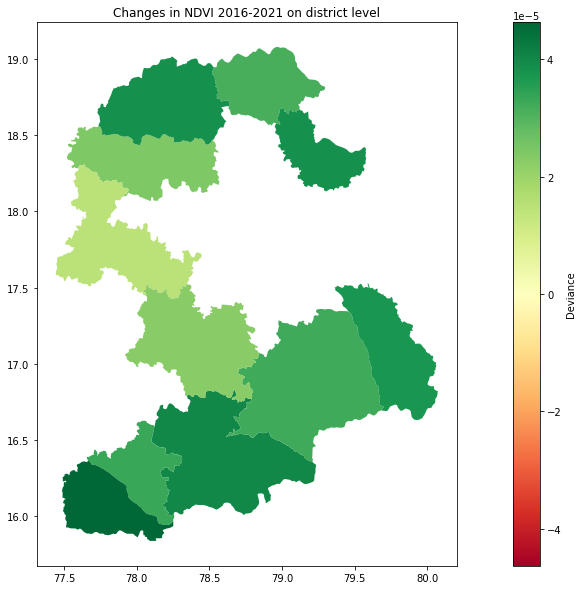

In [35]:
score_NDVI = correlation_function(NDVI_df, 2021, 'NDVI', district_bounds, 'district') # Run the correlation function to derive a positive deviance analysis plot

c:\Users\mieke\anaconda3\envs\thesis_base\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


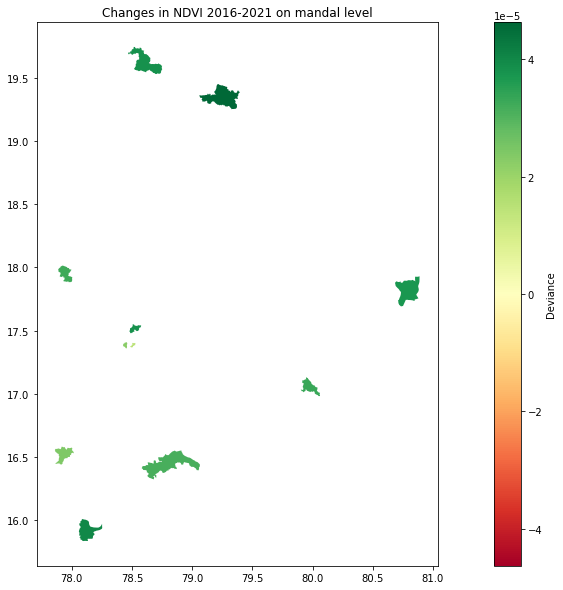

In [36]:
score_NDVI = correlation_function(NDVI_df, 2021, 'NDVI', mandal_bounds, 'mandal') # Run the correlation function to derive a positive deviance analysis plot

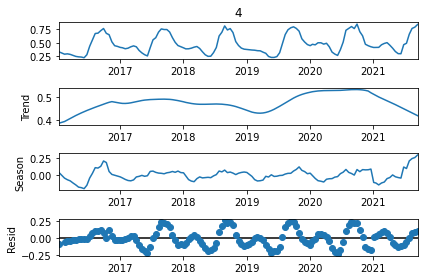

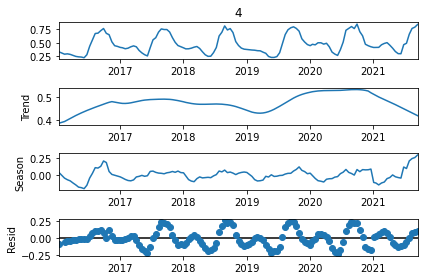

In [24]:
# In this cell, we select one datapoint to give more insight on what the trend looks like and which values we should assign to the period and season attribute
#  
index=4
df_selected = NDVI_df[['ModifiedDateTime', index]]
df_selected = df_selected.sort_values(by=['ModifiedDateTime'])
df_selected.index = df_selected['ModifiedDateTime']

X = df_selected[index]

# Decompose using STL Seasonal-Trend Decomposition using LOESS
stl = STL(X, period = 17, seasonal=5)
res = stl.fit()
res.plot()